## The German Traffic Sign Recognition Benchmark

In [1]:
# Importing libraries and frameworks
import pandas as pd
import cv2
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import ResNet50, MobileNet
from tensorflow.keras.applications import EfficientNetB0
from keras.layers import Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Set seeds to reproduce results
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
def load_data(csv_file_path, lenOfDatasetToUse):
    # Set seeds
    basePath = 'archive/'

    # read the path from the arguements
    data = pd.read_csv(csv_file_path)
    print(f"Using {lenOfDatasetToUse} images")

    # Randomize the order of data
    data = data.sample(frac=1, random_state=1).reset_index(drop=True)


    X = []
    y = []
    for i, row in data.head(lenOfDatasetToUse).iterrows():
        img_path = os.path.join(basePath, row['Path'])
        img = cv2.imread(img_path)

        # Continue if the image doesn't exist
        if img is None:
            continue

        # img = cv2.resize(img, (244, 244))
        # Scaling to 32x32
        img = cv2.resize(img, (32, 32))
        # Converting to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


        # Flattening the images
        X.append(img.flatten())
        y.append(row['ClassId'])

    # Conversion from python lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    return X, y

## Visualisation

In [3]:
# Use this to visualize the noise or any images from the dataset. It only takes in the image array as input and not a single image.
def visualize_images(images, num_samples=5, random=True):
    plt.figure(figsize=(15, 10))
    # Randomly choose images from the set to display
    chosen_indices = np.random.choice(len(images), num_samples, replace=False) if random else range(num_samples)
    
    for i, idx in enumerate(chosen_indices):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(images[idx])
    
    plt.tight_layout()
    plt.show()

In [4]:
# Graphs

# For all of the other algorithms except random forest and adaboost
def graphs(history, X_test, y_test, model):
    # Confusion Matrix
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="g")
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Loss Graph
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.figure(figsize=(12, 6))
    plt.plot(train_loss, label='Training Loss', color='blue')
    plt.plot(val_loss, label='Validation Loss', color='red')
    plt.title('Loss Graph')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.legend()
    plt.show()

# For random forest and adaboost, since they don't have  a loss graphs
def confMatrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

## Noise Addition, Fourier Transform and PCA

In [5]:
# Addition of Noise
def addNoise(X_test, ratio, flattenForRFAB=False):
    # Flatten if we are using Random Forest or Adaboost
    if flattenForRFAB:
        X_test = X_test.reshape((-1, 32, 32, 3))

    noisy_images = np.copy(X_test)
    num_samples, height, width, channels = X_test.shape
    total_pixels = num_samples * height * width
    num_pixels = int(ratio * total_pixels)
    
    # Random coordinates
    random_sample_coords = np.random.randint(0, num_samples, num_pixels)
    random_row_coords = np.random.randint(0, height, num_pixels)
    random_col_coords = np.random.randint(0, width, num_pixels)
    
    # Random colors
    random_colors = np.random.randint(0, 255, size=(num_pixels, channels))

    # Update chosen pixels with random colors
    for i in range(num_pixels):
        noisy_images[random_sample_coords[i], random_row_coords[i], random_col_coords[i], :] = random_colors[i]

    if flattenForRFAB:
        noisy_images = noisy_images.reshape((num_samples, -1))
    
    return noisy_images.astype(np.uint8)

In [6]:
# Fourier transformation
# Had to use a separate function since it's not working for an entire array, so using it on every image for simplification

def fourierTransform(image, handleFlattened=False):
    
    # Reshape the image to 32x32x3
    image = image.reshape((32, 32, 3))
    
    # New array to store the fourier transformed image
    reconstructed_image = np.zeros_like(image)
    
    # Reconstruct the image from the magnitude spectrum
    for channel in range(3):
        # Fourier transform
        f_transform = np.fft.fft2(image[:, :, channel])
        # Fourier shift
        f_transform_shifted = np.fft.fftshift(f_transform)
        # Taking the magnitude spectrum after the shift
        magnitude_spectrum = np.abs(f_transform_shifted)
        
        # Unshift the image pixels
        f_transform_unshifted = np.fft.ifftshift(magnitude_spectrum)
        # Perform inverse transform
        inverse_transform = np.fft.ifft2(f_transform_unshifted)
        
        reconstructed_image[:, :, channel] = np.abs(inverse_transform)
    
    return reconstructed_image

In [7]:
# Automation Function
# Change the PCA components according to the need. Our original experimentation used 300. Using 5 just for testing
def iterateNoise(X_test, y_test, model, usePca=False, pcaComponents=300, useFourier=False, RFAB=False):
    if RFAB:
        # Uncomment based on the usage
        # Noise threshold
        # noiseArr = [0.25]
        # Entire Noise Array
        noiseArr = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.20, 0.25]
    
    else:
        # Uncomment based on the usage
        # Entire noise array
        noiseArr = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
        # Noise threshold
        # noiseArr = [0.02]

    for i in noiseArr:
        if RFAB:
            X_test_noisy = addNoise(X_test, i, flattenForRFAB=True)
        else:
            X_test_noisy = addNoise(X_test, i)

        for j in range(2):
            # Using flags with for loop for automated work 
            if j == 0:
                print("Using just Fourier")
                useFourier = True
                usePca = False
            elif j == 1:
                print("Using just PCA")
                useFourier = False
                usePca = True

            if useFourier:
                print("Using Fourier(In statement)")
                # Transform the noisy test set using Fourier transform
                if RFAB:
                    X_test_transformed = np.array([fourierTransform(img, handleFlattened=True) for img in X_test_noisy])
                else:
                    X_test_transformed = np.array([fourierTransform(img) for img in X_test_noisy])
                


            if usePca:
                print("Using PCA(In statement)")
                X_test_flattened = X_test_noisy.reshape(X_test_noisy.shape[0], -1)
                pca = PCA(n_components=pcaComponents, whiten=False)
                X_test_pca = pca.fit_transform(X_test_flattened)
                
                # Inverse transformation to approximate original shape since this retains the effect of pca, but makes the image blurry!
                X_test_transformed = pca.inverse_transform(X_test_pca)
                X_test_transformed = X_test_transformed.reshape(X_test_noisy.shape)
            
            # Using the inbuilt functions to test the accuracy on noisy images
            if RFAB:
                X_test_transformed_flat = X_test_transformed.reshape(X_test_transformed.shape[0], -1)
                # Use the already trained model
                y_pred = model.predict(X_test_transformed_flat)  
                print(f"Accuracy with a noise ratio of {i}: {accuracy_score(y_test, y_pred)}")
            else:
                # Use the already trained model
                score = model.evaluate(X_test_transformed, y_test)
                print(f"Using noise ratio of {i}") 
                print('Test loss:', score[0])
                print('Test accuracy:', score[1])

## Algorithms

In [8]:
# Train Test Split
# Path to the dataset goes here
# Change the second parameter according to the size of data you want to run the code at
X, y = load_data('./archive/Train.csv', 27000) 
print(X.shape, y.shape)
print(X[0:5], y[0:5])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Using 200 images
(200, 3072) (200,)
[[ 33  38  31 ... 128 152 100]
 [255 255 255 ...  60  51  79]
 [ 18  17  20 ...   8   8  12]
 [182 145 161 ...  59  51  46]
 [ 15  15  17 ...  12  10  12]] [26 38 13  4 42]


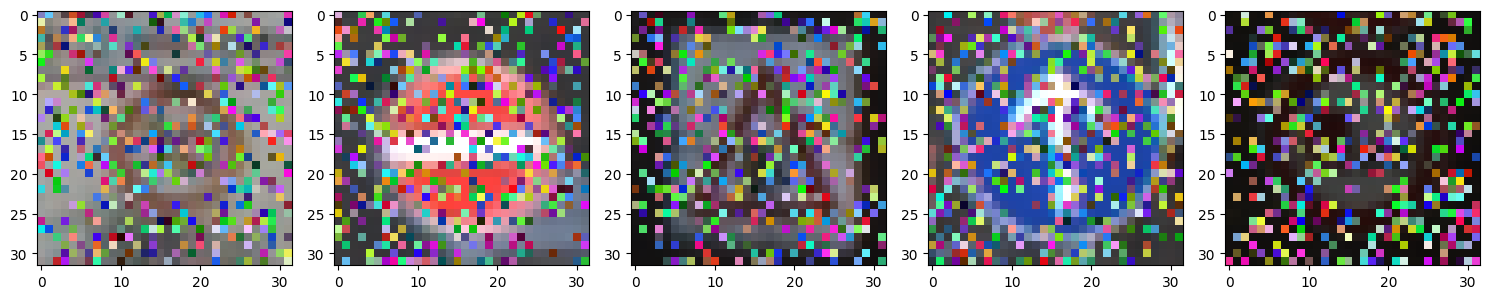

In [9]:
# Visualization of noise
# Change the second parameter in the function addNoise to see change in the noise
X_test_noisy = addNoise(X_test, 0.50, flattenForRFAB=True)
visualize_images(X_test_noisy.reshape(-1, 32, 32, 3), num_samples=5, random=True)


RandomForest Accuracy:  0.175


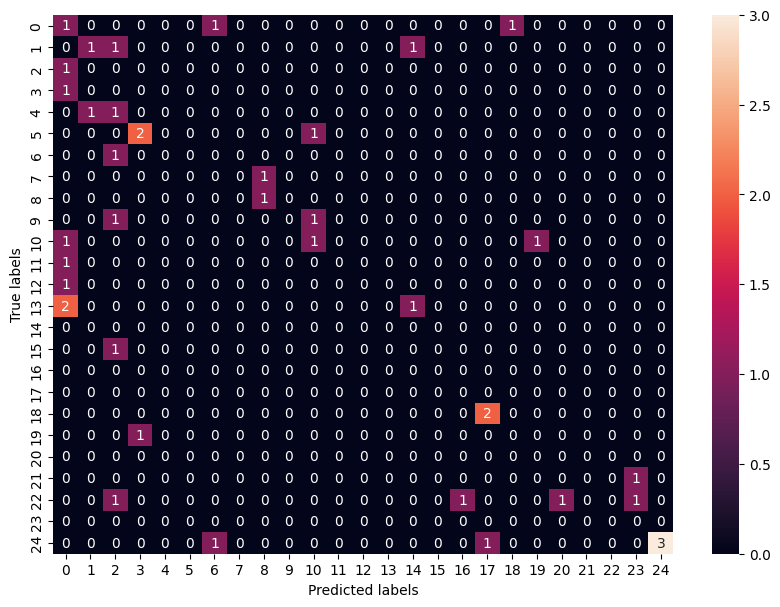

Using just Fourier
Using Fourier(In statement)
Accuracy with a noise ratio of 0.25: 0.05
Using just PCA
Using PCA(In statement)
Accuracy with a noise ratio of 0.25: 0.05


In [10]:
def randomForestClassifier(X_train, X_test, y_train, y_test):
        # Create the object
        randomForest = RandomForestClassifier(n_estimators=100, random_state=2)
        # Train
        randomForest.fit(X_train, y_train)
        
        # Predict and print the accuracy
        y_pred = randomForest.predict(X_test)
        print("RandomForest Accuracy: ", accuracy_score(y_test, y_pred))

        # Build the confusion matrix
        confMatrix(y_test, y_pred)

        return randomForest
        

# Call the function
rfClassifier = randomForestClassifier(X_train, X_test, y_train, y_test)

# To get noisy accuracy with Fourier and PCA
iterateNoise(X_test, y_test, rfClassifier, RFAB=True)

AdaBoost Accuracy:  0.1


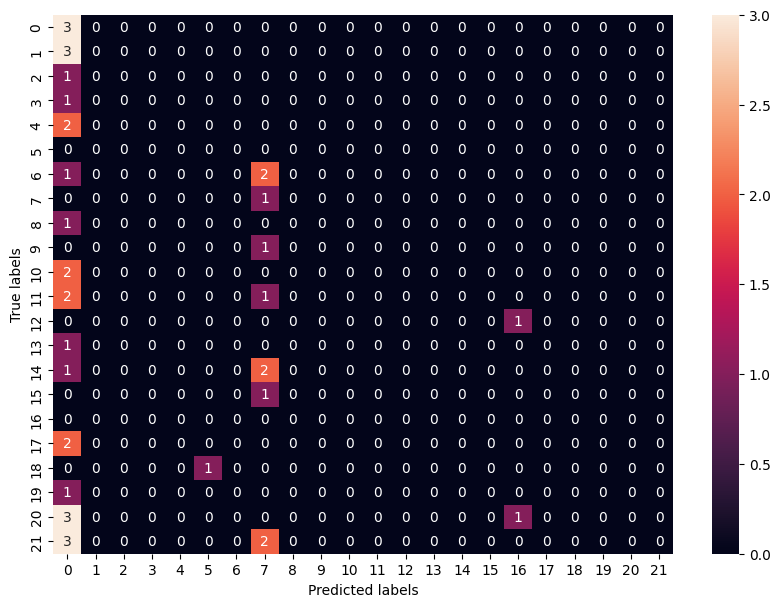

Using just Fourier
Using Fourier(In statement)
Accuracy with a noise ratio of 0.25: 0.1
Using just PCA
Using PCA(In statement)
Accuracy with a noise ratio of 0.25: 0.1


In [11]:
def adaBoostClassifier(X_train, X_test, y_train, y_test):
    # Create the object
    adaBoost = AdaBoostClassifier(n_estimators=100, random_state=2)
    # Train
    adaBoost.fit(X_train, y_train)

    # Test
    y_pred = adaBoost.predict(X_test)
    print("AdaBoost Accuracy: ", accuracy_score(y_test, y_pred))

    # Print the confusion matrix
    confMatrix(y_test, y_pred)
    return adaBoost

abClassifier = adaBoostClassifier(X_train, X_test, y_train, y_test)

# For fourier and PCA
iterateNoise(X_test, y_test, abClassifier, RFAB=True)

In [12]:
# Path to the dataset goes here
X, y = load_data('./archive/Train.csv', 27000) 
X = X.reshape(-1, 32, 32, 3)
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Convert the labels to categorical data
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

Using 200 images
(200, 32, 32, 3) (200,)


Epoch 1/5
5/5 [==============================] - 2s 267ms/step - loss: 3.7647 - accuracy: 0.0562 - val_loss: 7.4164 - val_accuracy: 0.1750
Epoch 2/5
5/5 [==============================] - 1s 169ms/step - loss: 1.6653 - accuracy: 0.6062 - val_loss: 6.4901 - val_accuracy: 0.2750
Epoch 3/5
5/5 [==============================] - 1s 170ms/step - loss: 0.8413 - accuracy: 0.8125 - val_loss: 5.9312 - val_accuracy: 0.2500
Epoch 4/5
5/5 [==============================] - 1s 171ms/step - loss: 0.5490 - accuracy: 0.8750 - val_loss: 5.4440 - val_accuracy: 0.2750
Epoch 5/5
5/5 [==============================] - 1s 170ms/step - loss: 0.3458 - accuracy: 0.9375 - val_loss: 5.3016 - val_accuracy: 0.3000
Using just Fourier
Using Fourier(In statement)
2/2 [==============================] - 0s 46ms/step - loss: 18.8171 - accuracy: 0.0750
Using noise ratio of 0.02
Test loss: 18.817096710205078
Test accuracy: 0.07500000298023224
Using just PCA
Using PCA(In statement)
2/2 [==============================] - 0s

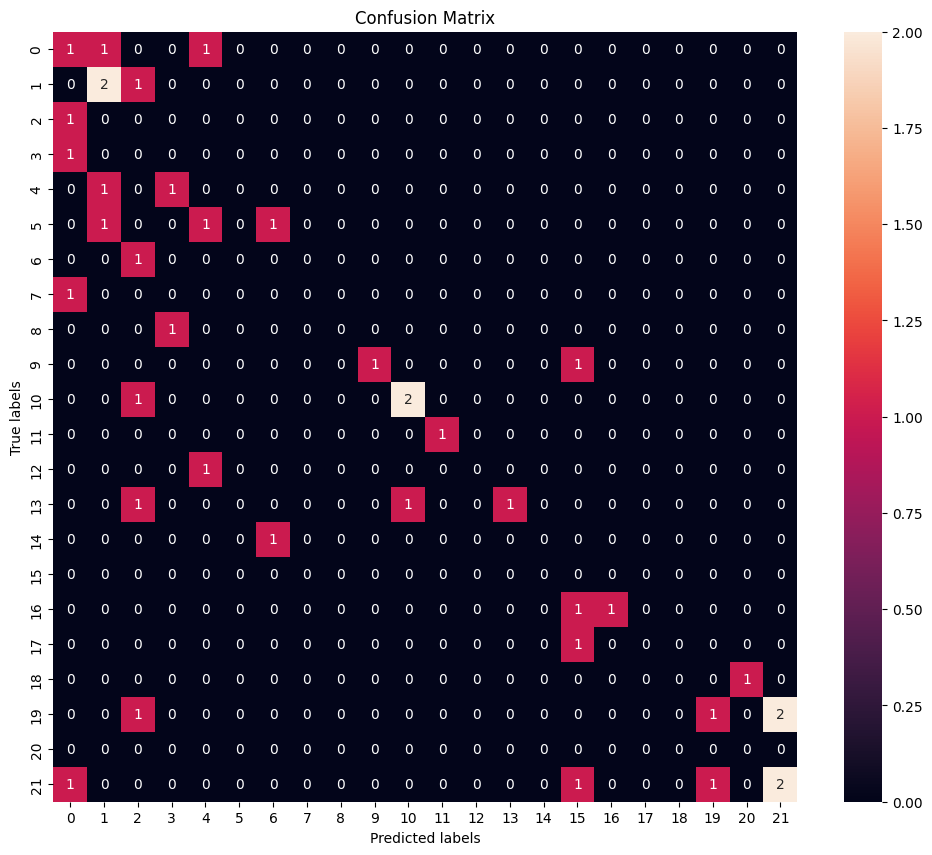

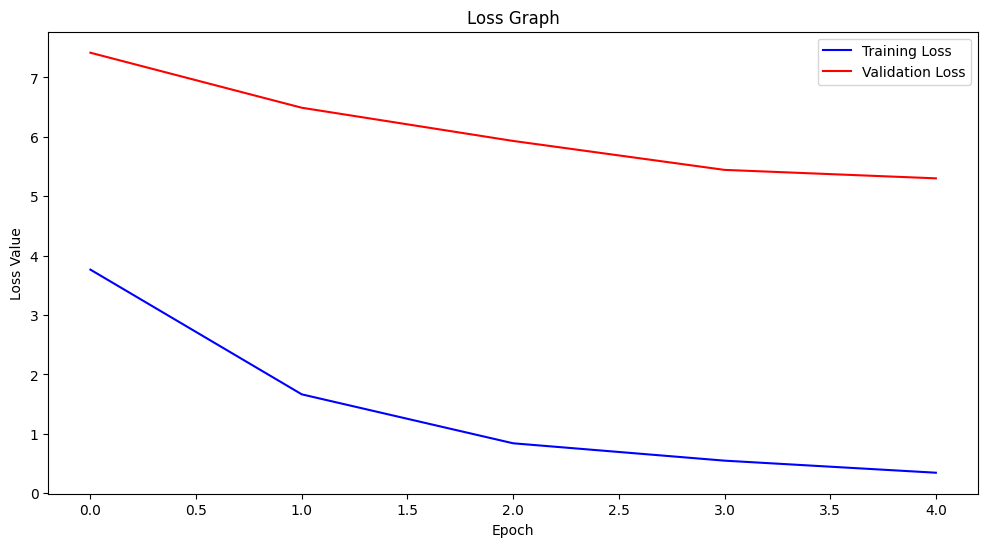

In [13]:
def VGG16Model(num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    # Add a global spatial average pooling layer
    x = base_model.output
    x = BatchNormalization()(x)
    x = Flatten()(x)

    # Add a fully-connected layer
    x = Dense(1024, activation='relu')(x)

    # And a logistic layer
    predictions = Dense(num_classes, activation='softmax')(x)

    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    return model


model = VGG16Model(43)

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

modelHistory = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

iterateNoise(X_test, y_test, model)

graphs(modelHistory, X_test, y_test, model)

Epoch 1/5
5/5 [==============================] - 2s 277ms/step - loss: 3.7339 - accuracy: 0.0688 - val_loss: 5.2277 - val_accuracy: 0.2000
Epoch 2/5
5/5 [==============================] - 1s 214ms/step - loss: 1.6102 - accuracy: 0.6187 - val_loss: 5.0455 - val_accuracy: 0.3000
Epoch 3/5
5/5 [==============================] - 1s 209ms/step - loss: 0.7895 - accuracy: 0.8438 - val_loss: 5.2976 - val_accuracy: 0.2250
Epoch 4/5
5/5 [==============================] - 1s 219ms/step - loss: 0.4961 - accuracy: 0.9000 - val_loss: 5.3792 - val_accuracy: 0.2250
Epoch 5/5
5/5 [==============================] - 1s 210ms/step - loss: 0.3004 - accuracy: 0.9438 - val_loss: 5.4078 - val_accuracy: 0.1500
Using just Fourier
Using Fourier(In statement)
2/2 [==============================] - 0s 74ms/step - loss: 17.3526 - accuracy: 0.0000e+00
Using noise ratio of 0.02
Test loss: 17.35259437561035
Test accuracy: 0.0
Using just PCA
Using PCA(In statement)
2/2 [==============================] - 0s 61ms/step - 

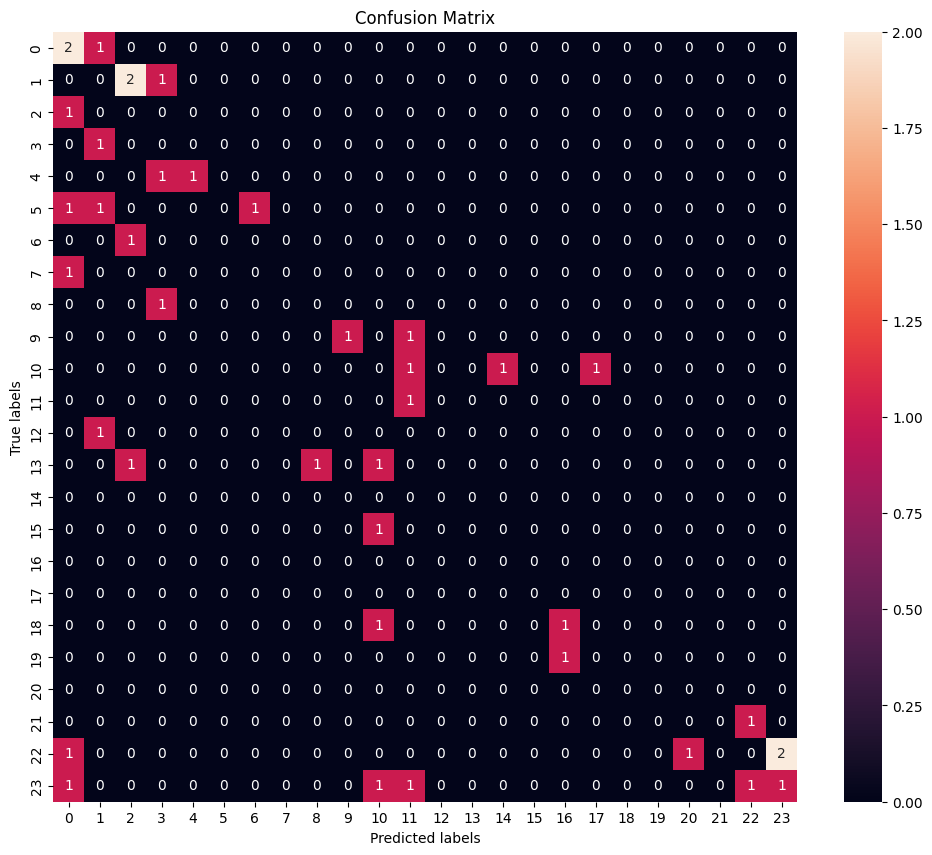

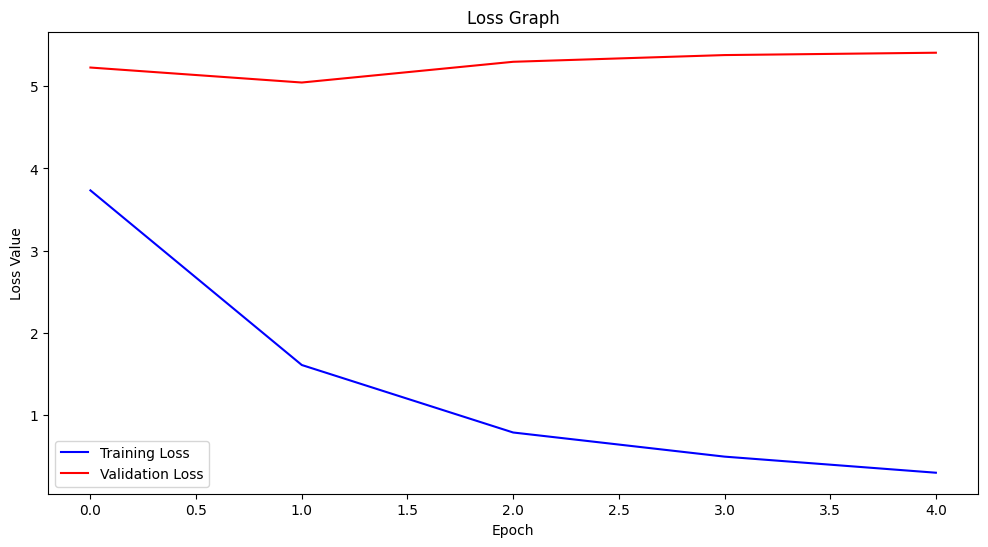

In [14]:
def VGG19Model(num_classes):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    # Add a global spatial average pooling layer
    x = base_model.output
    x = BatchNormalization()(x)
    x = Flatten()(x)

    # Add a fully-connected layer
    x = Dense(1024, activation='relu')(x)

    # # And a logistic layer
    predictions = Dense(num_classes, activation='softmax')(x)

    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False
        
    return model

model = VGG19Model(43)

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

modelHistory = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

iterateNoise(X_test, y_test, model)

graphs(modelHistory, X_test, y_test, model)

Epoch 1/5
5/5 [==============================] - 2s 280ms/step - loss: 0.2586 - accuracy: 0.9563 - val_loss: 5.4600 - val_accuracy: 0.1750
Epoch 2/5
5/5 [==============================] - 1s 222ms/step - loss: 0.1153 - accuracy: 0.9688 - val_loss: 5.3731 - val_accuracy: 0.2000
Epoch 3/5
5/5 [==============================] - 1s 217ms/step - loss: 0.0831 - accuracy: 0.9875 - val_loss: 5.5598 - val_accuracy: 0.1750
Epoch 4/5
5/5 [==============================] - 1s 214ms/step - loss: 0.0518 - accuracy: 1.0000 - val_loss: 5.7059 - val_accuracy: 0.1750
Epoch 5/5
5/5 [==============================] - 1s 212ms/step - loss: 0.0560 - accuracy: 0.9875 - val_loss: 5.8296 - val_accuracy: 0.2000
Using just Fourier
Using Fourier(In statement)
2/2 [==============================] - 0s 61ms/step - loss: 21.2826 - accuracy: 0.0250
Using noise ratio of 0.02
Test loss: 21.28260612487793
Test accuracy: 0.02500000037252903
Using just PCA
Using PCA(In statement)
2/2 [==============================] - 0s 

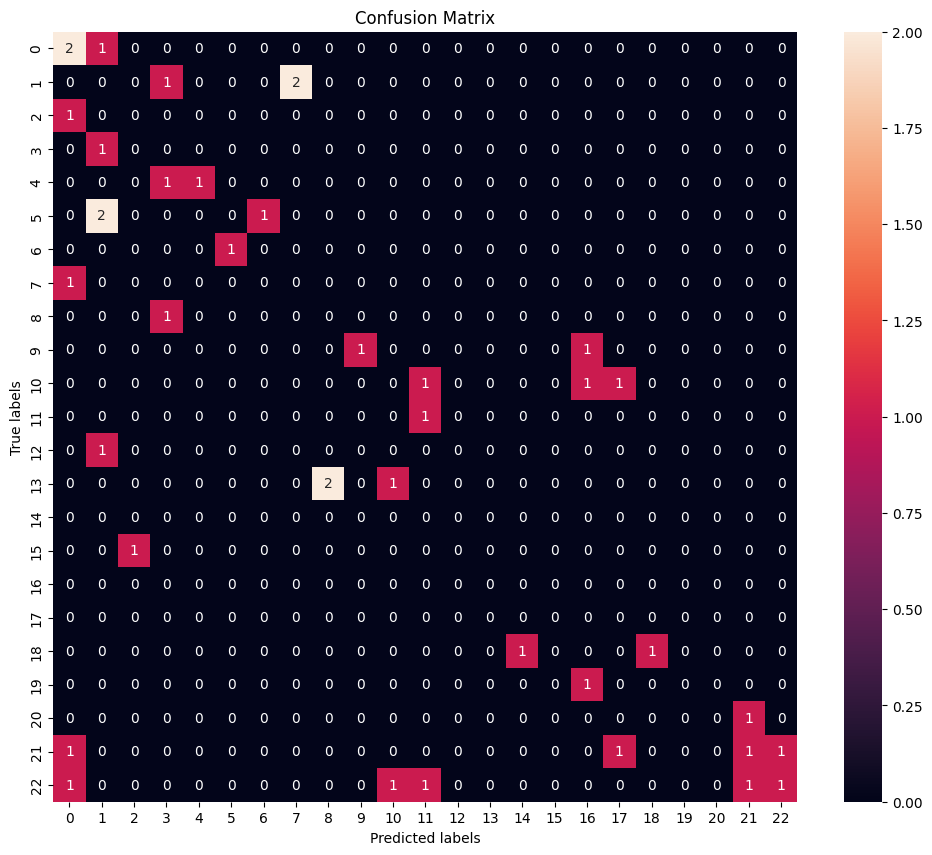

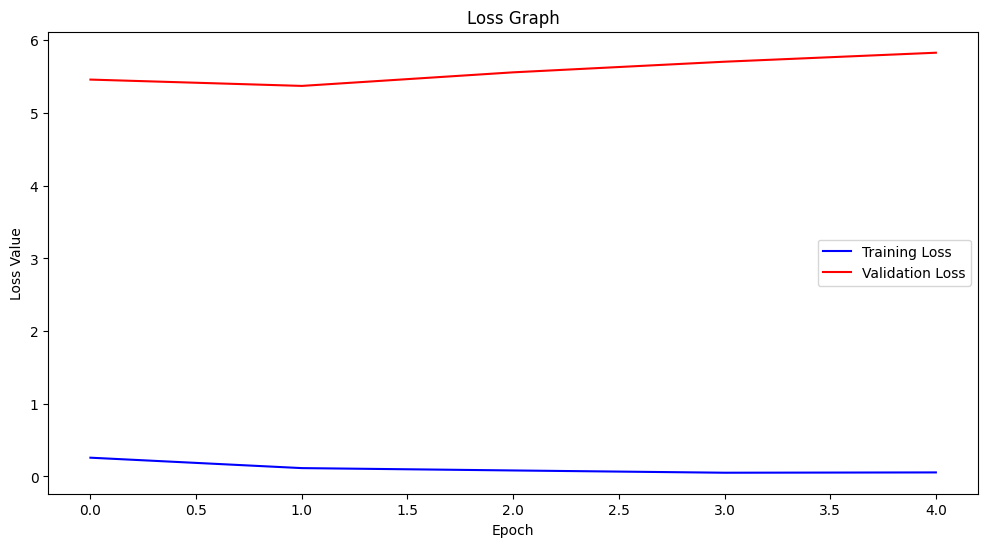

In [15]:
def ResNet(num_classes):
    base_model = ResNet50(weights=None, include_top=False, input_shape=(32, 32, 3))

    # Add a global spatial average pooling layer
    x = base_model.output
    x = BatchNormalization()(x)
    x = Flatten()(x)

    # Add a fully-connected layer
    x = Dense(1024, activation='relu')(x)

    # # And a logistic layer
    predictions = Dense(num_classes, activation='softmax')(x)

    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False
    
    return model

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

modelHistory = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

iterateNoise(X_test, y_test, model)

graphs(modelHistory, X_test, y_test, model)

Epoch 1/5
5/5 [==============================] - 3s 276ms/step - loss: 0.0270 - accuracy: 0.9937 - val_loss: 5.7579 - val_accuracy: 0.2250
Epoch 2/5
5/5 [==============================] - 1s 213ms/step - loss: 0.0252 - accuracy: 0.9875 - val_loss: 5.9156 - val_accuracy: 0.2250
Epoch 3/5
5/5 [==============================] - 1s 211ms/step - loss: 0.0203 - accuracy: 0.9937 - val_loss: 6.1899 - val_accuracy: 0.2500
Epoch 4/5
5/5 [==============================] - 1s 209ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 6.4171 - val_accuracy: 0.2000
Epoch 5/5
5/5 [==============================] - 1s 197ms/step - loss: 0.0192 - accuracy: 0.9937 - val_loss: 6.5699 - val_accuracy: 0.2500
Using just Fourier
Using Fourier(In statement)
2/2 [==============================] - 0s 60ms/step - loss: 24.0386 - accuracy: 0.0250
Using noise ratio of 0.02
Test loss: 24.038558959960938
Test accuracy: 0.02500000037252903
Using just PCA
Using PCA(In statement)
2/2 [==============================] - 0s

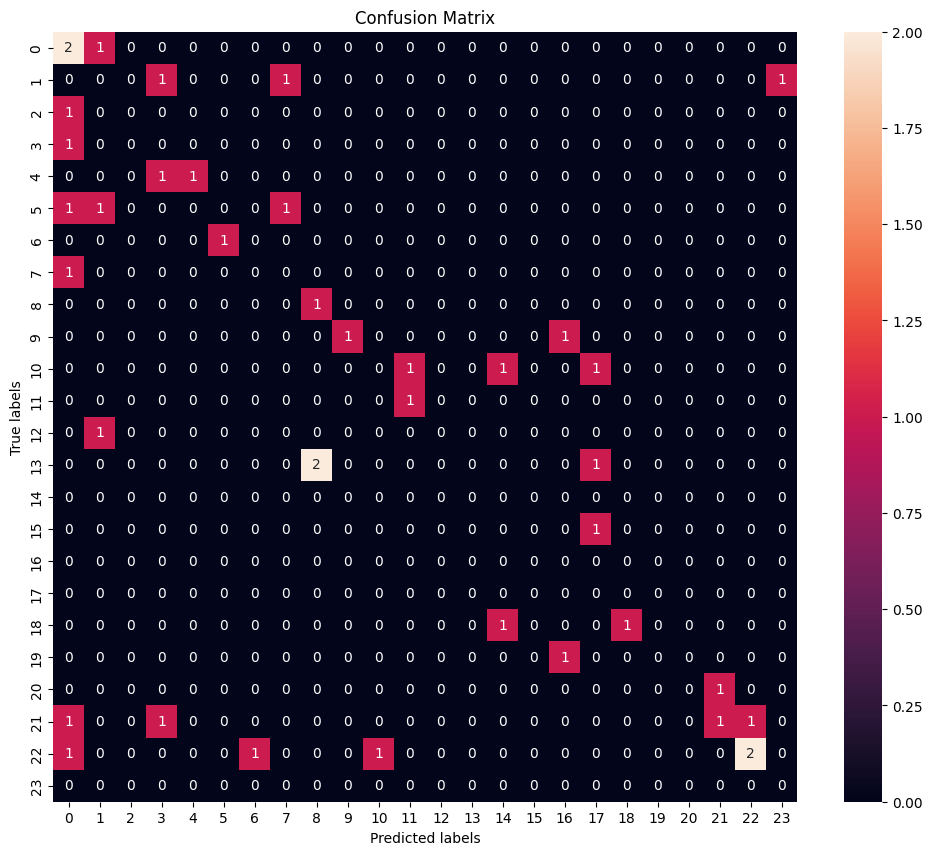

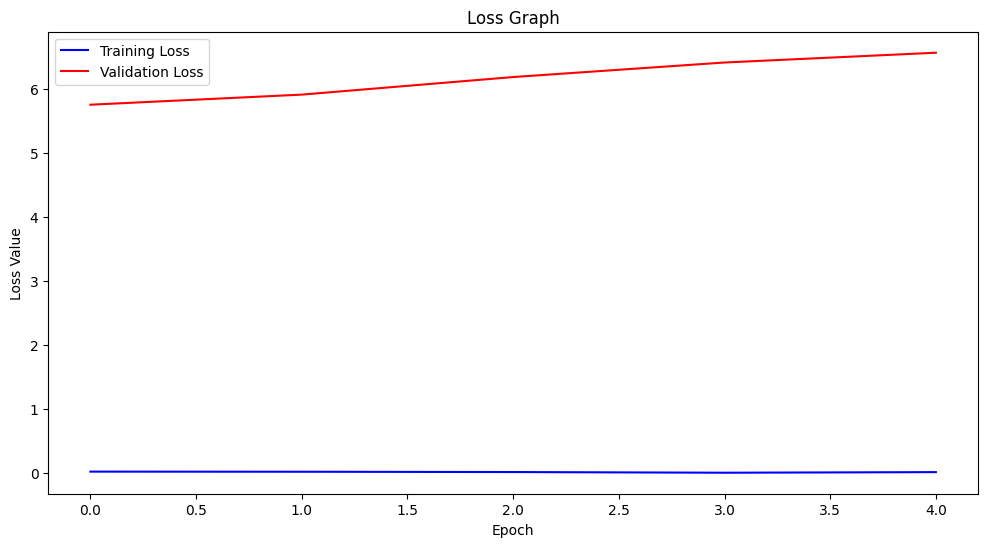

In [16]:
def EfficientNet(num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    # Add a global spatial average pooling layer
    x = base_model.output
    x = BatchNormalization()(x)
    x = Flatten()(x)

    # Add a fully-connected layer
    x = Dense(1024, activation='relu')(x)

    # # And a logistic layer
    predictions = Dense(num_classes, activation='softmax')(x)

    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False
    
    return model

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

modelHistory = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

iterateNoise(X_test, y_test, model)

graphs(modelHistory, X_test, y_test, model)

Epoch 1/5
5/5 [==============================] - 2s 279ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 6.7790 - val_accuracy: 0.2250
Epoch 2/5
5/5 [==============================] - 1s 207ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 6.7567 - val_accuracy: 0.2000
Epoch 3/5
5/5 [==============================] - 1s 205ms/step - loss: 0.0078 - accuracy: 0.9937 - val_loss: 6.9401 - val_accuracy: 0.1750
Epoch 4/5
5/5 [==============================] - 1s 211ms/step - loss: 0.0111 - accuracy: 0.9937 - val_loss: 7.1394 - val_accuracy: 0.2250
Epoch 5/5
5/5 [==============================] - 1s 196ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 7.3208 - val_accuracy: 0.2250
Using just Fourier
Using Fourier(In statement)
2/2 [==============================] - 0s 60ms/step - loss: 28.2511 - accuracy: 0.0250
Using noise ratio of 0.02
Test loss: 28.251079559326172
Test accuracy: 0.02500000037252903
Using just PCA
Using PCA(In statement)
2/2 [==============================] - 0s

2/2 [==============================] - 0s 59ms/step


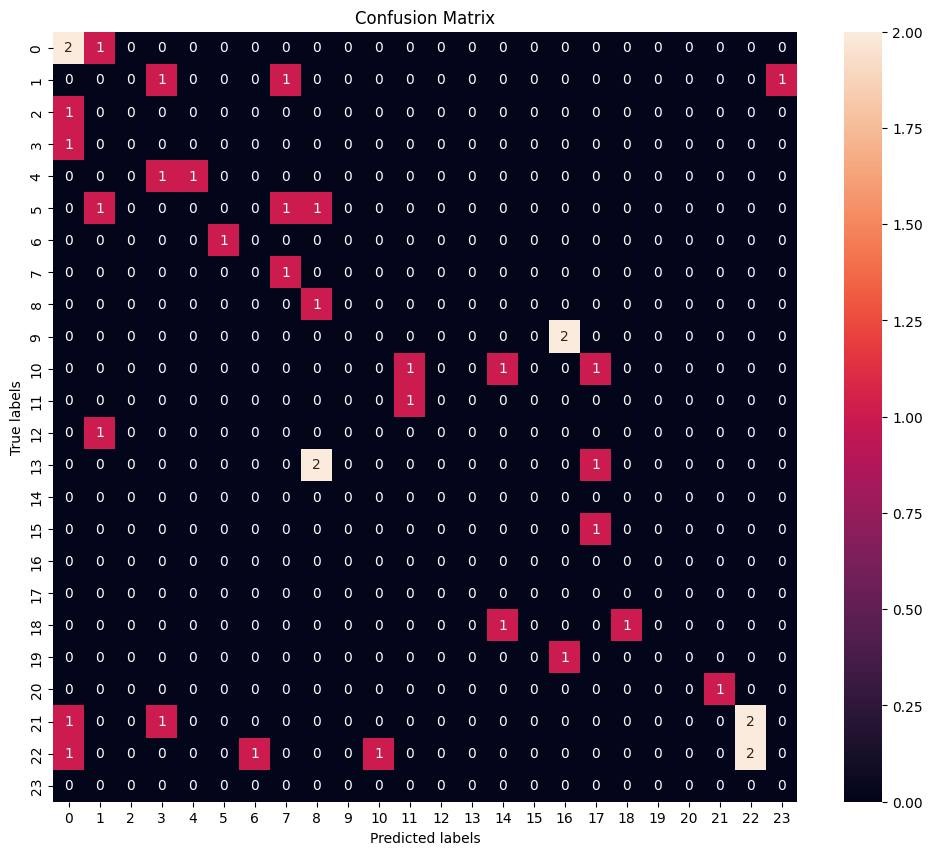

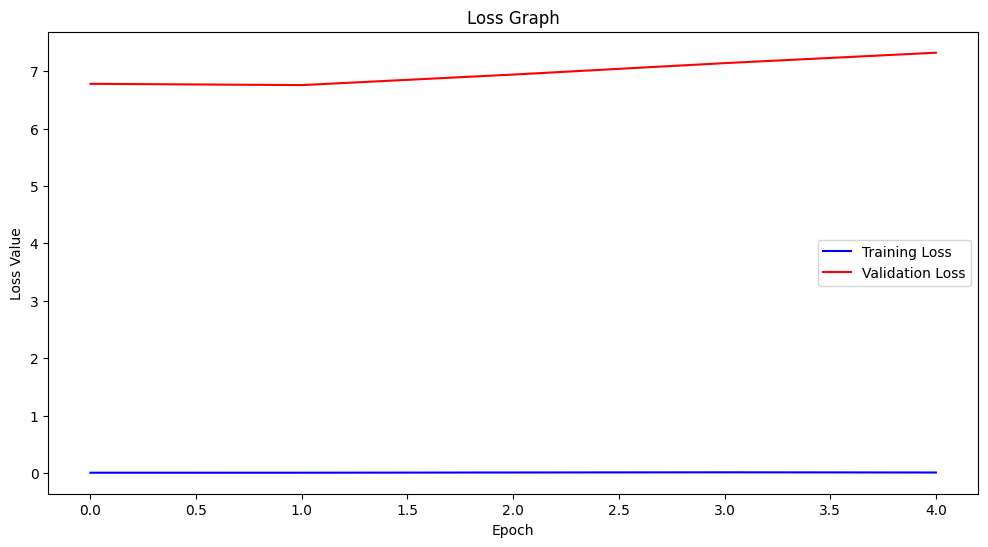

In [17]:
def MobileNet(num_classes):
    base_model = MobileNet(weights=None, include_top=False, input_shape=(32, 32, 3))

    # Add a global spatial average pooling layer
    x = base_model.output
    x = BatchNormalization()(x)
    x = Flatten()(x)

    # Add a fully-connected layer
    x = Dense(1024, activation='relu')(x)

    # # And a logistic layer
    predictions = Dense(num_classes, activation='softmax')(x)

    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False
    
    return model

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

modelHistory = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

iterateNoise(X_test, y_test, model)

graphs(modelHistory, X_test, y_test, model)

## References

In [18]:
# References for code
# https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/code
# https://stackoverflow.com/questions/60620082/importing-a-dataframe-from-one-jupyter-notebook-into-another-jupyter-notebook
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iterrows.html
# https://towardsdatascience.com/adaboost-from-scratch-37a936da3d50
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
# https://www.datacamp.com/tutorial/adaboost-classifier-python
# https://stackoverflow.com/questions/23628325/cv2-imread-checking-if-image-is-being-read
# https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
# https://stackoverflow.com/questions/44091023/how-to-use-pre-trained-features-from-vgg-16-as-input-to-globalaveragepooling2d
# https://github.com/keras-team/keras/issues/10450
# https://builtin.com/machine-learning/vgg16
# https://github.com/AarohiSingla/VGG-16/blob/main/vggnet_with_keras_own_dataset.ipynb
# https://stackoverflow.com/questions/66365670/hstack-a-noise-and-image
# https://gist.github.com/Prasad9/28f6a2df8e8d463c6ddd040f4f6a028a?permalink_comment_id=2933012
# https://stackoverflow.com/questions/44843581/what-is-the-difference-between-model-fit-an-model-evaluate-in-keras
# https://towardsdatascience.com/image-processing-with-python-application-of-fourier-transformation-5a8584dc175b
# https://www.scaler.com/topics/numpy-fft/
# https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_transforms/py_fourier_transform/py_fourier_transform.html
# https://medium.com/@sebastiannorena/pca-principal-components-analysis-applied-to-images-of-faces-d2fc2c083371#:~:text=PCA%20is%20very%20useful%20for,better%20understanding%20of%20the%20data.
# https://medium.com/@lawrence.may/using-tensorflow-for-classification-on-the-gtsrb-german-traffic-sign-dataset-d71e5557a015
# https://datascience.stackexchange.com/questions/33286/how-to-print-a-confusion-matrix-from-random-forests-in-python
# https://homepages.inf.ed.ac.uk/rbf/HIPR2/fourier.htm
# https://www.mathworks.com/help/images/fourier-transform.html
# https://medium.com/@jalalmansoori/how-to-perform-fourier-transformation-in-image-using-matlab-2403084bf97a
# https://numpy.org/doc/stable/reference/generated/numpy.fft.ifft.html
# https://numpy.org/doc/stable/reference/generated/numpy.fft.fft2.html
# https://numpy.org/doc/stable/reference/generated/numpy.fft.ifft2.html
# https://numpy.org/doc/stable/reference/generated/numpy.fft.fftn.html
# https://towardsdatascience.com/principal-component-analysis-in-depth-understanding-through-image-visualization-892922f77d9f
# https://towardsdatascience.com/image-compression-using-principal-component-analysis-pca-253f26740a9f
# https://medium.com/analytics-vidhya/principal-component-analysis-of-an-image-7e62105b2fa2
# https://medium.com/data-science-365/principal-component-analysis-pca-with-scikit-learn-1e84a0c731b0
# https://www.kdnuggets.com/2023/05/principal-component-analysis-pca-scikitlearn.html
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
# https://stats.stackexchange.com/questions/95806/how-to-whiten-the-data-using-principal-component-analysis
# https://paulbourke.net/miscellaneous/imagefilter/
# https://terpconnect.umd.edu/~toh/spectrum/FourierFilter.html#:~:text=The%20Fourier%20filter%20is%20a,finally%20inverse%20transforming%20the%20result
# https://dsp.stackexchange.com/questions/27566/whats-a-fourier-filter
# https://www.geeksforgeeks.org/add-a-salt-and-pepper-noise-to-an-image-with-python/
# https://www.datacamp.com/tutorial/principal-component-analysis-in-python
# https://medium.com/analytics-vidhya/principal-component-analysis-of-an-image-7e62105b2fa2#:~:text=Principal%20Component%20Analysis%20is%20a,the%20data%20to%202%20dimensions.
# https://www.mathworks.com/help/images/fourier-transform.html
# https://vincmazet.github.io/bip/filtering/fourier.html
# https://towardsdatascience.com/image-compression-using-principal-component-analysis-pca-253f26740a9f?gi=3132e1709dd5
# https://www.section.io/engineering-education/image-compression-using-pca/
# https://matplotlib.org/
# https://seaborn.pydata.org/examples/index.html
# https://scikit-learn.org/stable/modules/ensemble.html
# https://www.tensorflow.org/api_docs/python/tf/keras/applications